# Goal:
Make a function that returns the ingredients which are a common combination with the entered ingredient

In [6]:
import pandas as pd #Data manipulation
import numpy as np #Array and Matrix operations
import matplotlib.pyplot as plt #Plotting
import seaborn as sb #Plotting
sb.set()

# Dataset Preparation
The following steps are taken to prepare the data for EDA as well as model training:
1. The `id` column is set as the index
2. The Dataframe is sorted based on the `id` column
3. We convert all ingredients to lowercase

In [7]:
#DataFrame manipulation
data = pd.read_json("data/train.json")
data = data.set_index("id") 
data = data.sort_values("id")
data.ingredients = data.ingredients.apply(lambda ings : [ing.lower() for ing in ings]) #Lower case all ingredients
data.head()

,cuisine,ingredients
id,,
0,spanish,"[mussels, ground black pepper, garlic cloves, ..."
1,mexican,"[tomatoes, diced red onions, paprika, salt, co..."
2,french,"[chicken broth, truffles, pimentos, green pepp..."
3,chinese,"[fresh ginger, sesame oil, frozen peas, cooked..."
4,italian,"[orange peel, cookies, vanilla ice cream, gran..."


# Ingredient Co-occurrence
The simplest method to recommend ingredients is to see which 2 inredients occur the most together.
We use `itertools.combinations` which goes through an array and makes a combination of 2 ingredients for the entire array

In [12]:
#Calculating ingredient co-occurrences
import itertools
from collections import Counter
cooc_counts = Counter()
ing_count = Counter()

for ingredients in data.ingredients:
    for ing in ingredients:
        ing_count[ing] += 1
    for(ing_a, ing_b) in itertools.combinations(set(ingredients), 2):
        #We want the pairs of ingredients in a consistent order(alphabetically)
        if(ing_a > ing_b):
            ing_a, ing_b = ing_b, ing_a
        cooc_counts[(ing_a, ing_b)] += 1

In [11]:
cooc_df = pd.DataFrame(((ing_a, ing_b, ing_count[ing_a], ing_count[ing_b], cooc) for (ing_a, ing_b), cooc in cooc_counts.items()), columns=['a', 'b', 'a_count', 'b_count', 'cooc'])
cooc_df.sample(10)

,a,b,a_count,b_count,cooc
131276,hot red pepper flakes,scallions,171,1891,26
126019,hot water,purple onion,356,1896,7
199172,provolone cheese,whole milk,165,764,1
322679,peppercorns,whole wheat pasta,144,18,1
166013,poppy seeds,tumeric,70,738,5
385504,brandy,salted butter,169,77,1
20723,basmati rice,cumin,326,953,14
99768,baking soda,coriander,942,458,6
310193,chestnut spread,rum,1,77,1
292601,corn,fish sauce,329,1247,2


In [23]:
#Find ingredients most common with Condensed Milk
cooc_df[cooc_df.a == 'condensed milk'].sort_values('cooc', ascending=False).head(10)

,a,b,a_count,b_count,cooc
40206,condensed milk,sugar,74,6434,335
84288,condensed milk,water,74,7457,254
40203,condensed milk,eggs,74,3388,208
71303,condensed milk,vanilla extract,74,1298,200
47909,condensed milk,milk,74,2263,170
86936,condensed milk,salt,74,18049,140
71302,condensed milk,egg yolks,74,542,132
79018,condensed milk,unsalted butter,74,2782,124
86938,condensed milk,flour,74,1348,117
217510,condensed milk,sweet potatoes,74,455,113


As we can see, the most common ingredients are not those which would be common in a recipe with the input ingredient, but are ingredients which are common as a whole in the entire dataset. E.g. Sugar, water, etc.  
___

The clear problem is that co-occurrences are skewed by ingredient frequency in the dataset as mentioned above.

To solve this problem we use something known as ***Pointwise Mutual Information(PMI)*** :
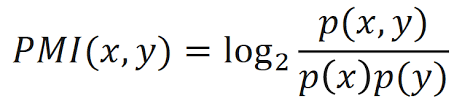

**P(X) = Counts(X)/(Total Recipes in Dataset)**  
**P(Y) = Counts(Y)/(Total Recipes in Dataset)**  
**P(X, Y) = Co-occurrence(X, Y)/(Sum of Total Co-occurrences in Dataset)**

The numerator in the formula signifies the **Probability of 2 ingredients occurring together**  
The denominator in the formula signifies the **Probability of 2 ingredients occurring separately**

Therefore, this formula also takes into account the fact that ingredients may be more common but may not occur together.

In [13]:
p_a = cooc_df.a_count / sum(ing_count.values())
p_b = cooc_df.b_count / len(ing_count.values())
p_a_b = cooc_df.cooc / cooc_df.cooc.sum()
cooc_df['pmi'] = np.log(p_a_b / (p_a * p_b))

In [14]:
cooc_df.sort_values('pmi', ascending=False).head(10)

,a,b,a_count,b_count,cooc,pmi
84920,pippin apples,rum raisin ice cream,1,1,1,7.053491
156112,garbonzo bean,whole garam masala,1,1,1,7.053491
377072,dried oysters,wood mushrooms,1,1,1,7.053491
414820,dipping chocolate,ground nuts,1,1,1,7.053491
444769,america,chilcostle chile,1,1,1,7.053491
267642,mccormick taco seasoning,tomato sauce low sodium,1,1,1,7.053491
430338,gluten free chicken broth,nonhydrogenated margarine,1,1,1,7.053491
209170,conimex wok olie,conimex woksaus specials vietnamese gember kno...,1,1,1,7.053491
473038,vanilla vodka,white creme de cacao,1,1,1,7.053491
314061,dried allspice berries,soup bones,1,1,1,7.053491


We see ingredients which have a very low occurrence in the overall dataset and can be removed  
`Note:` This also shows that instead of just using ingredients as a single entity, we should treat them like n-grams (Olive Oil and Virgin Olive Oil should be treated similarly)

In [26]:
min_count = 5
cooc_df[(cooc_df.a_count >= min_count) & (cooc_df.b_count >= min_count)].sort_values('pmi', ascending=False).head(20)

,a,b,a_count,b_count,cooc,pmi
194612,kewra water,stone flower,6,6,86,5.243554
155714,herdez salsa casera,herdez salsa verde,5,6,42,4.709198
332638,sazon seasoning,sofrito,5,5,33,4.650357
313701,black rice vinegar,chinese sesame paste,9,5,52,4.517307
34053,mo hanh,vegan mayonnaise,5,6,34,4.497889
194602,shahi jeera,stone flower,20,6,130,4.452768
194603,kewra water,shahi jeera,6,20,128,4.437264
446524,burger buns,sweet yellow corn,5,5,26,4.411946
263403,black fungus,lily buds,5,8,40,4.372726
212555,flat iron steaks,fudge brownie mix,9,6,52,4.334985


Using a minimum criteria of 5 occurrences shows that some ingredients have the brand names mentioned in them (E.g. Herdez Salsa Casera, Shahi Jeera, etc.). The brand names have nothing to do with cuisine and just increase unique ingredient count.

In [27]:
min_count = 30
cooc_df[(cooc_df.a_count >= min_count) & (cooc_df.b_count >= min_count)].sort_values('pmi', ascending=False).head(20)

,a,b,a_count,b_count,cooc,pmi
54947,brown cardamom,green cardamom,40,86,603,2.631416
57109,brown cardamom,mace,40,81,366,2.192030
31831,gari,wasabi,50,32,169,2.124866
111385,mexican chocolate,plantains,32,38,128,2.121434
264843,baby corn,straw mushrooms,37,31,97,1.902532
26584,asafoetida powder,fresh curry leaves,33,69,185,1.862467
134601,galangal,shrimp paste,85,56,368,1.812806
32124,green cardamom,mace,86,81,529,1.794918
125956,fenugreek,mustard oil,36,32,82,1.730190
31849,sushi rice,wasabi,81,32,180,1.705497


Using a minimum criteria of 30 occurrences begins to show real relationships

In [28]:
min_count = 30
cooc_df[(cooc_df.a_count >= min_count) & (cooc_df.b_count >= min_count) & (cooc_df.cooc > 1)].sort_values('pmi', ascending=True).head(20)

,a,b,a_count,b_count,cooc,pmi
414244,fresh lime juice,milk,1368,2263,5,-8.963388
388483,cucumber,unsalted butter,768,2782,6,-8.410230
132995,garlic cloves,vanilla extract,6237,1298,30,-8.132911
350224,onions,vanilla extract,7972,1298,43,-8.018345
312803,dried oregano,ginger,1707,1755,13,-7.975042
382285,grated parmesan cheese,sesame oil,1886,1773,15,-7.941866
161716,dried oregano,fresh ginger,1707,1503,13,-7.820036
436052,all-purpose flour,lemongrass,4632,364,9,-7.767948
396237,ground cinnamon,sesame oil,1231,1773,12,-7.738378
283364,soy sauce,whipping cream,3296,619,12,-7.670938


If we ignore those ingredient pairs with just 1 co-occurrence and negative PMI, we see ingredients which don't have any co-occurrence (E.g. Soy Sauce and Whipping Cream).

This is because in the PMI, their denominator was greater than the numerator, making the log negative.  
___

# Matrix Factorisation
We are currently only using direct correlations between 2 ingredients. For example, there are 10 recipes in which `Spaghetti` and `Oregano` appear together. This means we are ignoring more subtle relations. `Parmesan` might not be in many recipes with `Spaghetti` but it could be in many recipes which are closely related to `Spaghetti` as well.

To fix this sparseness situation (where most ingredient pairs have around no correlation ), we use a technique called matric factorisation:
1. Make a matrix where Rows and Columns are all the ingredients and the intersecting values are the PMI values
2. We factorize the matrix - split an NxN matrix into a smaller NxK matrix where K<N (We take K = 120 since it gives good results)

Matrix factorisation removes noisy data and generalises the knowledge to all ingredients. The output is a vector for each ingredient which we can compare with vectors of other ingredients. 

In [15]:
#Using matrix factorization
from scipy.sparse import csr_matrix
data_df = cooc_df[cooc_df.pmi > 0].copy()
# Since the matrix is symetric, we add the same values for (b,a) as we have for (a,b)
data_df_t = data_df.copy()
data_df.a, data_df.b = data_df.b, data_df.a
data_df = pd.concat([data_df, data_df_t])

rows_idx, row_keys = pd.factorize(data_df.a)
cols_idx, col_keys = pd.factorize(data_df.b)
values = data_df.pmi

matrix = csr_matrix((values, (rows_idx, cols_idx)))
key_to_row = {key: idx for idx, key in enumerate(row_keys)}

In [16]:
from sklearn.decomposition import TruncatedSVD

#Using Singular Value Decomposition to reduce dimensionality
svd = TruncatedSVD(200)
factors = svd.fit_transform(matrix)

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
def most_similar(ingredient, topn=10):
    if ingredient not in key_to_row:
        print("Unknown ingredient.")
    factor = factors[key_to_row[ingredient]]
    cosines = cosine_similarity([factor], factors)[0]
    indices = cosines.argsort()[::-1][:topn + 1]
    keys = [row_keys[idx] for idx in indices if idx != key_to_row[ingredient]]
    return keys, cosines[indices]

def display_most_similar(ingredient, topn=10):
    print("- Most similar to '{}'".format(ingredient))
    for similar_ing, score in zip(*most_similar(ingredient, topn)):
        print("  . {} : {:.2f}".format(similar_ing, score))    

In [29]:
display_most_similar('naan')

- Most similar to 'naan'
  . cream yogurt : 1.00
  . chickpeas : 0.82
  . foccacia : 0.77
  . chicken fillets : 0.77
  . natural low-fat yogurt : 0.76
  . basmati rice : 0.76
  . fresh ginger root : 0.76
  . flora original : 0.76
  . knorr chicken stock cubes : 0.76
  . fresh coriander : 0.76
